## Libs

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
import os
from tqdm import tqdm

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Dados

In [192]:
DB_FATURAMENTO_PATH = './data/raw/faturamento_lojas_atuais.csv'
DB_EXPANSAO_PATH    = './data/raw/cenarios_expansao.csv'
DB_ATUAL_PATH       = './data/raw/lojas_atuais.csv'

In [193]:
DB_FATURAMENTO = pd.read_csv(DB_FATURAMENTO_PATH)
DB_EXPANSAO    = pd.read_csv(DB_EXPANSAO_PATH)
DB_ATUAL       = pd.read_csv(DB_ATUAL_PATH)

## Preprocessamento

In [194]:
DB_EXPANSAO.head().T

,0,1,2,3,4
cod_loja,10,13,16,21,28
cod_ap,2933307005008,2916401003002,2928703003003,2906006003001,3550308005058
cod_municipio,2933307,2916401,2928703,2906006,3550308
feature_01,FEATURE_01_VALUE_08,FEATURE_01_VALUE_10,NaN,NaN,FEATURE_01_VALUE_10
feature_02,FEATURE_02_VALUE_02,FEATURE_02_VALUE_04,FEATURE_02_VALUE_04,FEATURE_02_VALUE_04,FEATURE_02_VALUE_02
feature_03,False,False,False,False,True
feature_04,50,41,42.12,30,44.31
feature_05,FEATURE_05_VALUE_03,FEATURE_05_VALUE_03,FEATURE_05_VALUE_05,FEATURE_05_VALUE_03,FEATURE_05_VALUE_03
feature_06,6,4,2,6,8
feature_07,0.134654,0.116662,0.104162,0.132954,0.190102


In [195]:
DB_EXPANSAO.isna().sum()

cod_loja           0
cod_ap             0
cod_municipio      0
feature_01       364
feature_02         0
feature_03         0
feature_04         0
feature_05         0
feature_06         0
feature_07         0
feature_08         0
feature_09         0
feature_10         0
feature_11       512
feature_12       512
feature_13       394
feature_14       394
feature_15       394
feature_16       394
feature_17       394
feature_18       394
dtype: int64

### Missing columns

In [196]:
drop_cols = ['feature_01', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
             'feature_17', 'feature_18']

DB_EXPANSAO_SM = DB_EXPANSAO.drop(drop_cols, axis = 1)
DB_ATUAL_SM    = DB_ATUAL.drop(drop_cols, axis = 1)

In [197]:
DB_ATUAL_SM.groupby('cod_municipio').count().sort_values(by="cod_loja", ascending=False)

,cod_loja,cod_ap,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10
cod_municipio,,,,,,,,,,,
3550308,184,184,184,184,184,184,184,184,184,184,184
-1,151,151,151,151,151,151,151,151,151,151,151
3304557,70,70,70,70,70,70,70,70,70,70,70
5300108,35,35,35,35,35,35,35,35,35,35,35
3509502,33,33,33,33,33,33,33,33,33,33,33
...,...,...,...,...,...,...,...,...,...,...,...
3205069,1,1,1,1,1,1,1,1,1,1,1
3205176,1,1,1,1,1,1,1,1,1,1,1
2412005,1,1,1,1,1,1,1,1,1,1,1


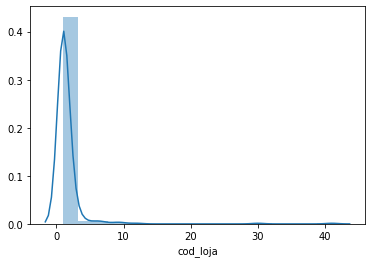

In [188]:
sns.distplot(DB_EXPANSAO_SM.groupby('cod_municipio').count().sort_values(by="cod_loja", ascending=False)['cod_loja'])

In [189]:
def cod_heuristic_municipio(db, threshold = 1):
    '''
    Categorizo as lojas de acordo com a quantidade de lojas existentes no cod_municipio
    
    cod_heuristic = {
        -1 se cod_municipio == -1
        0  se sum(cod_municipio) == threshold
        1  se sum(cod_municipio) > threshold
    }
    '''
    
    count = db.groupby('cod_municipio').count().sort_values(by="cod_loja", ascending=False)['cod_loja']
    
    cod_heuristic = []
    
    for i in range(len(db)):
        row = db.loc[i]
        
        cod_municipio = row.cod_municipio
        
        if cod_municipio == -1:
            cod_heuristic.append(-1)
            
        elif count[cod_municipio] == threshold:
            cod_heuristic.append(0)
            
        else:
            cod_heuristic.append(1)
            
    db['cod_heuristic_municipio'] = cod_heuristic
    
    return db

def cod_heuristic_ap(db, threshold = 1):
    '''
    Categorizo as lojas de acordo com a quantidade de lojas existentes no cod_ap
    
    cod_heuristic = {
        -1 se cod_ap == -1
        0  se sum(cod_ap) == threshold
        1  se sum(cod_ap) > threshold
    }
    '''
    
    count = db.groupby('cod_ap').count().sort_values(by="cod_loja", ascending=False)['cod_loja']
    
    cod_heuristic = []
    
    for i in range(len(db)):
        row = db.loc[i]
        
        cod_ap = row.cod_ap
        
        if cod_ap == -1:
            cod_heuristic.append(-1)
            
        elif count[cod_ap] == threshold:
            cod_heuristic.append(0)
            
        else:
            cod_heuristic.append(1)
            
    db['cod_heuristic_ap'] = cod_heuristic
    
    return db

def scale_cols(db, cols = ['feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10',
                           'cod_heuristic_ap', 'cod_heuristic_municipio', 'feature_03']):
    '''
    Aplico StandardScaler nas colunas cols de DB e retorno a base escalada e o scaler
    '''
    
    scaler = StandardScaler()
    
    
    db[cols] = scaler.fit_transform(db[cols].values)
    
    return db, scaler

def apply_scale(db, scaler, cols = ['feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 
                                    'feature_10', 'cod_heuristic_ap', 'cod_heuristic_municipio', 'feature_03']):
    '''
    Aplica o scaler nas cols de db
    '''
    
    db[cols] = scaler.transform(db[cols].values)
    
    return db
    


#### Pipeline

In [199]:
# Dropando colunas desnecessárias
drop_cols = ['feature_01', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
             'feature_17', 'feature_18']

DB_EXPANSAO_SM = DB_EXPANSAO.drop(drop_cols, axis = 1)
DB_ATUAL_SM    = DB_ATUAL.drop(drop_cols, axis = 1)

# Aplicando heuristicas sobre localidades com mais e menos lojas
DB_EXPANSAO_SM = cod_heuristic_municipio(DB_EXPANSAO_SM)
DB_ATUAL_SM    = cod_heuristic_municipio(DB_ATUAL_SM)

DB_EXPANSAO_SM = cod_heuristic_ap(DB_EXPANSAO_SM)
DB_ATUAL_SM    = cod_heuristic_ap(DB_ATUAL_SM)

# Alterando tipo True/False
DB_ATUAL_SM['feature_03']    = DB_ATUAL_SM['feature_03'].apply(lambda x : 1 if x else -1)
DB_EXPANSAO_SM['feature_03'] = DB_EXPANSAO_SM['feature_03'].apply(lambda x : 1 if x else -1)

# Aplicando StandardScaler
DB_ATUAL_SM, scaler = scale_cols(DB_ATUAL_SM)
DB_EXPANSAO_SM      = apply_scale(DB_EXPANSAO_SM, scaler)

# Selecionando colunas para Kmeans
drop_cols = ['cod_loja', 'cod_ap', 'cod_municipio', 'feature_02', 'feature_05']

DB_EXPANSAO_SM = DB_EXPANSAO_SM.drop(drop_cols, axis = 1)
DB_ATUAL_SM    = DB_ATUAL_SM.drop(drop_cols, axis = 1)

X_train = DB_ATUAL_SM.copy()
X_test  = DB_EXPANSAO_SM.copy()

X_train

,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,cod_heuristic_municipio,cod_heuristic_ap
0,1.716693,-0.898721,5.155081,-0.082478,0.007412,-0.352416,-0.595727,0.778248,1.276277
1,1.716693,-0.881399,4.340233,0.928539,0.623350,0.697221,-0.097693,0.778248,1.276277
2,1.716693,0.826317,0.062285,0.372700,0.246087,3.622002,-0.420024,0.778248,-0.535399
3,-0.582515,-0.303980,-0.548850,-0.661279,-0.491166,-0.427244,1.239604,0.778248,1.276277
4,-0.582515,2.041061,4.951369,-1.399879,-1.335101,-0.200365,-0.737808,0.778248,1.276277
...,...,...,...,...,...,...,...,...,...
3125,-0.582515,-0.292432,-0.141427,0.806512,0.004084,-0.410140,-0.165389,-0.925190,-0.535399
3126,-0.582515,0.273439,1.488268,-0.569392,-0.307838,-0.317875,-0.721283,0.778248,1.276277
3127,-0.582515,0.709390,0.265997,1.164060,1.516592,-0.424314,0.198229,0.778248,1.276277
3128,-0.582515,-0.176948,-0.345139,-0.825349,-0.650177,-0.421627,0.001117,0.778248,1.276277


#### Kmeans (validação)

In [200]:
n_clusters_test_list = [1,3,6,9,12,15,18,21,24,27]
kmeans_res = []

for n_clusters in n_clusters_test_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=480978).fit(X_train.values)
    
    kmeans_res.append(kmeans)

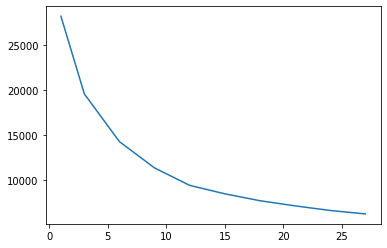

In [201]:
plt.plot(n_clusters_test_list, [res.inertia_ for res in kmeans_res])

#### Kmeans (aplicação)

In [226]:
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=1221321).fit(X_train.values)

DB_ATUAL['class'] = kmeans.labels_
DB_EXPANSAO['class'] = kmeans.predict(X_test)

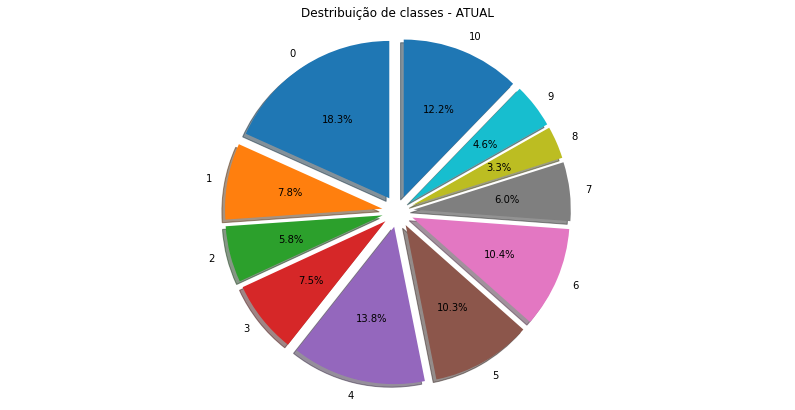

In [227]:
class_count = DB_ATUAL.groupby('class').count()['cod_loja']

sizes  = class_count.values
labels = class_count.index
explode = [0.1 for i in range(len(sizes))]

fig1, ax1 = plt.subplots(figsize=(14, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.title('Destribuição de classes - ATUAL')
plt.show()

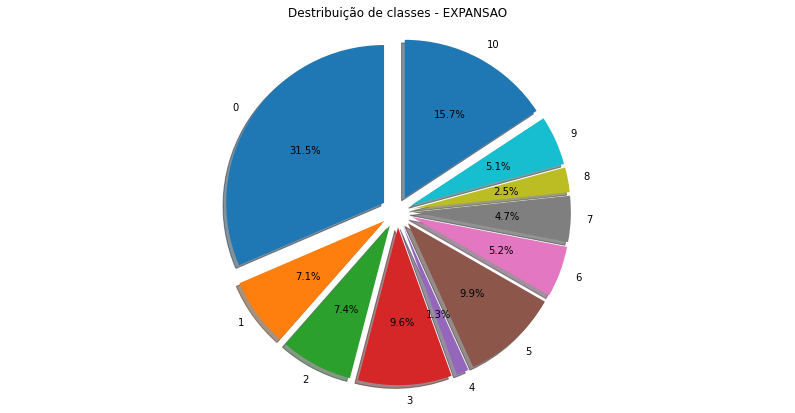

In [228]:
class_count = DB_EXPANSAO.groupby('class').count()['cod_loja']

sizes  = class_count.values
labels = class_count.index
explode = [0.1 for i in range(len(sizes))]

fig1, ax1 = plt.subplots(figsize=(14, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.title('Destribuição de classes - EXPANSAO')
plt.show()

A partir daqui, a ideia seria dado que podemos inferir quais lojas pertencem a quais "classes" então, podemos gerar uma série temporal com os dados necessários para fazer a predição da tarefa 1 para as lojas do cenário de expansão.

### Trabalhando com o faturamento

In [219]:
DB_FATURAMENTO

,cod_loja,ano,mes,categoria,qtde,receita
0,1,2016,1,CATEG_01,301.0,9164.86
1,1,2016,2,CATEG_01,187.0,8175.55
2,1,2016,3,CATEG_01,242.0,10521.67
3,1,2016,4,CATEG_01,104.0,4560.91
4,1,2016,5,CATEG_01,100.0,4263.30
...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60
1003090,3687,2017,9,CATEG_14,33.0,62.70
1003091,3687,2017,10,CATEG_14,184.0,349.60
1003092,3687,2017,11,CATEG_14,28.0,61.30


In [229]:
def calc_offset_date(ano, mes, min_ano = None, min_mes = None):
    '''
    Retorna o valor de offset_date
    '''
    
    if not min_ano:
        min_ano = DB_FATURAMENTO.ano.min()
    
    if not min_mes:
        min_mes = DB_FATURAMENTO[DB_FATURAMENTO.ano == min_ano].mes.min()
        
    offset_date = (ano - min_ano) * (12) + mes - min_mes
    
    return offset_date

def get_offset_date():
    '''
    Coleta o vetor de offset_date
    '''   
        
    min_ano = DB_FATURAMENTO.ano.min()
    min_mes = DB_FATURAMENTO[DB_FATURAMENTO.ano == min_ano].mes.min()
    
    offset_date_list = []
    
    for i in tqdm(range(len(DB_FATURAMENTO))):
        
        row = DB_FATURAMENTO.loc[i]
        offset_date = calc_offset_date(row.ano, row.mes, min_ano, min_mes)
        offset_date_list.append(offset_date)
        
    return offset_date_list

In [230]:
DB_FATURAMENTO_SM = DB_FATURAMENTO.copy()

DB_FATURAMENTO_SM['offset_date'] = get_offset_date()

100%|██████████| 1003094/1003094 [02:54<00:00, 5742.61it/s]


In [246]:
%%time

temp = DB_ATUAL.set_index('cod_loja')

DB_FATURAMENTO_SM['class'] = DB_FATURAMENTO_SM['cod_loja'].apply(lambda cod : temp.loc[cod]['class'])

CPU times: user 2min 19s, sys: 46.1 ms, total: 2min 19s
Wall time: 2min 19s


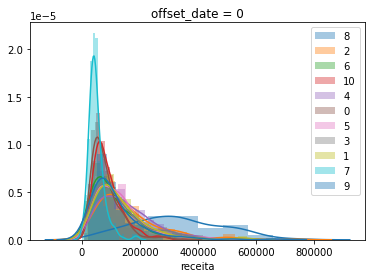

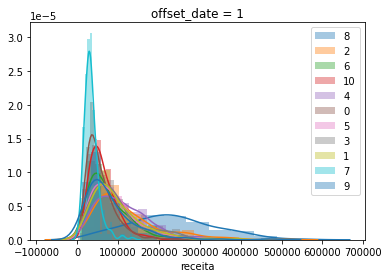

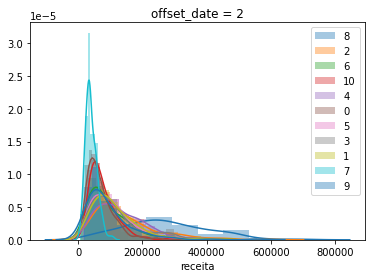

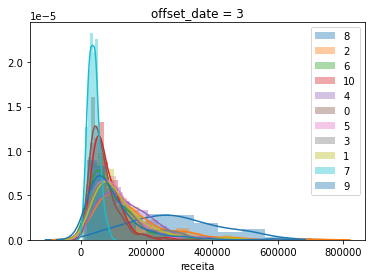

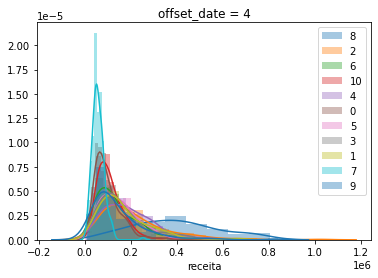

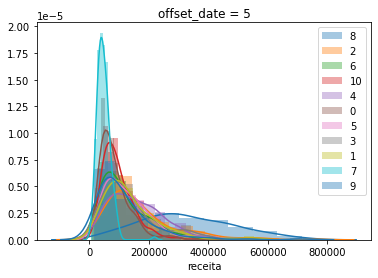

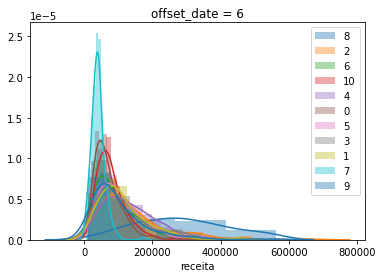

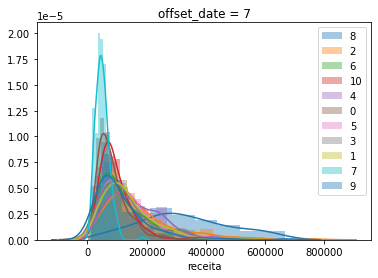

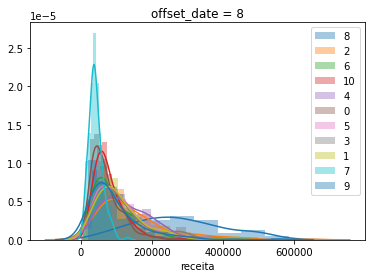

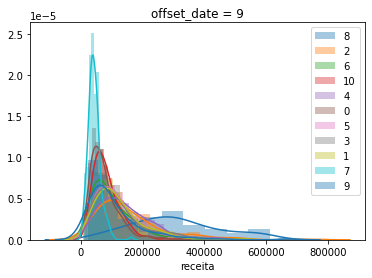

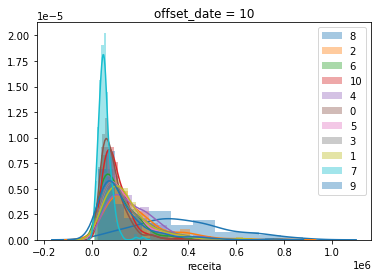

In [285]:
for offset_date in range(0, 11):
    
    plt.figure()
    plt.title('offset_date = ' + str(offset_date))
    for class_ in DB_ATUAL['class'].unique():
        class_data = DB_FATURAMENTO_SM[DB_FATURAMENTO_SM['class'] == class_]
        sns.distplot(class_data[class_data['offset_date'] == offset_date].groupby('cod_loja').sum()['receita'].values, label=class_)
    plt.legend()
    plt.xlabel('receita')